In [2]:
# load and autoreload
from IPython import get_ipython
# noinspection PyBroadException
try:
    _magic = get_ipython().magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass
    

import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

In [3]:
Counss = [['Peru'],['Bolivia'],['Ecuador'],['Colombia']]

lm = {}

In [12]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


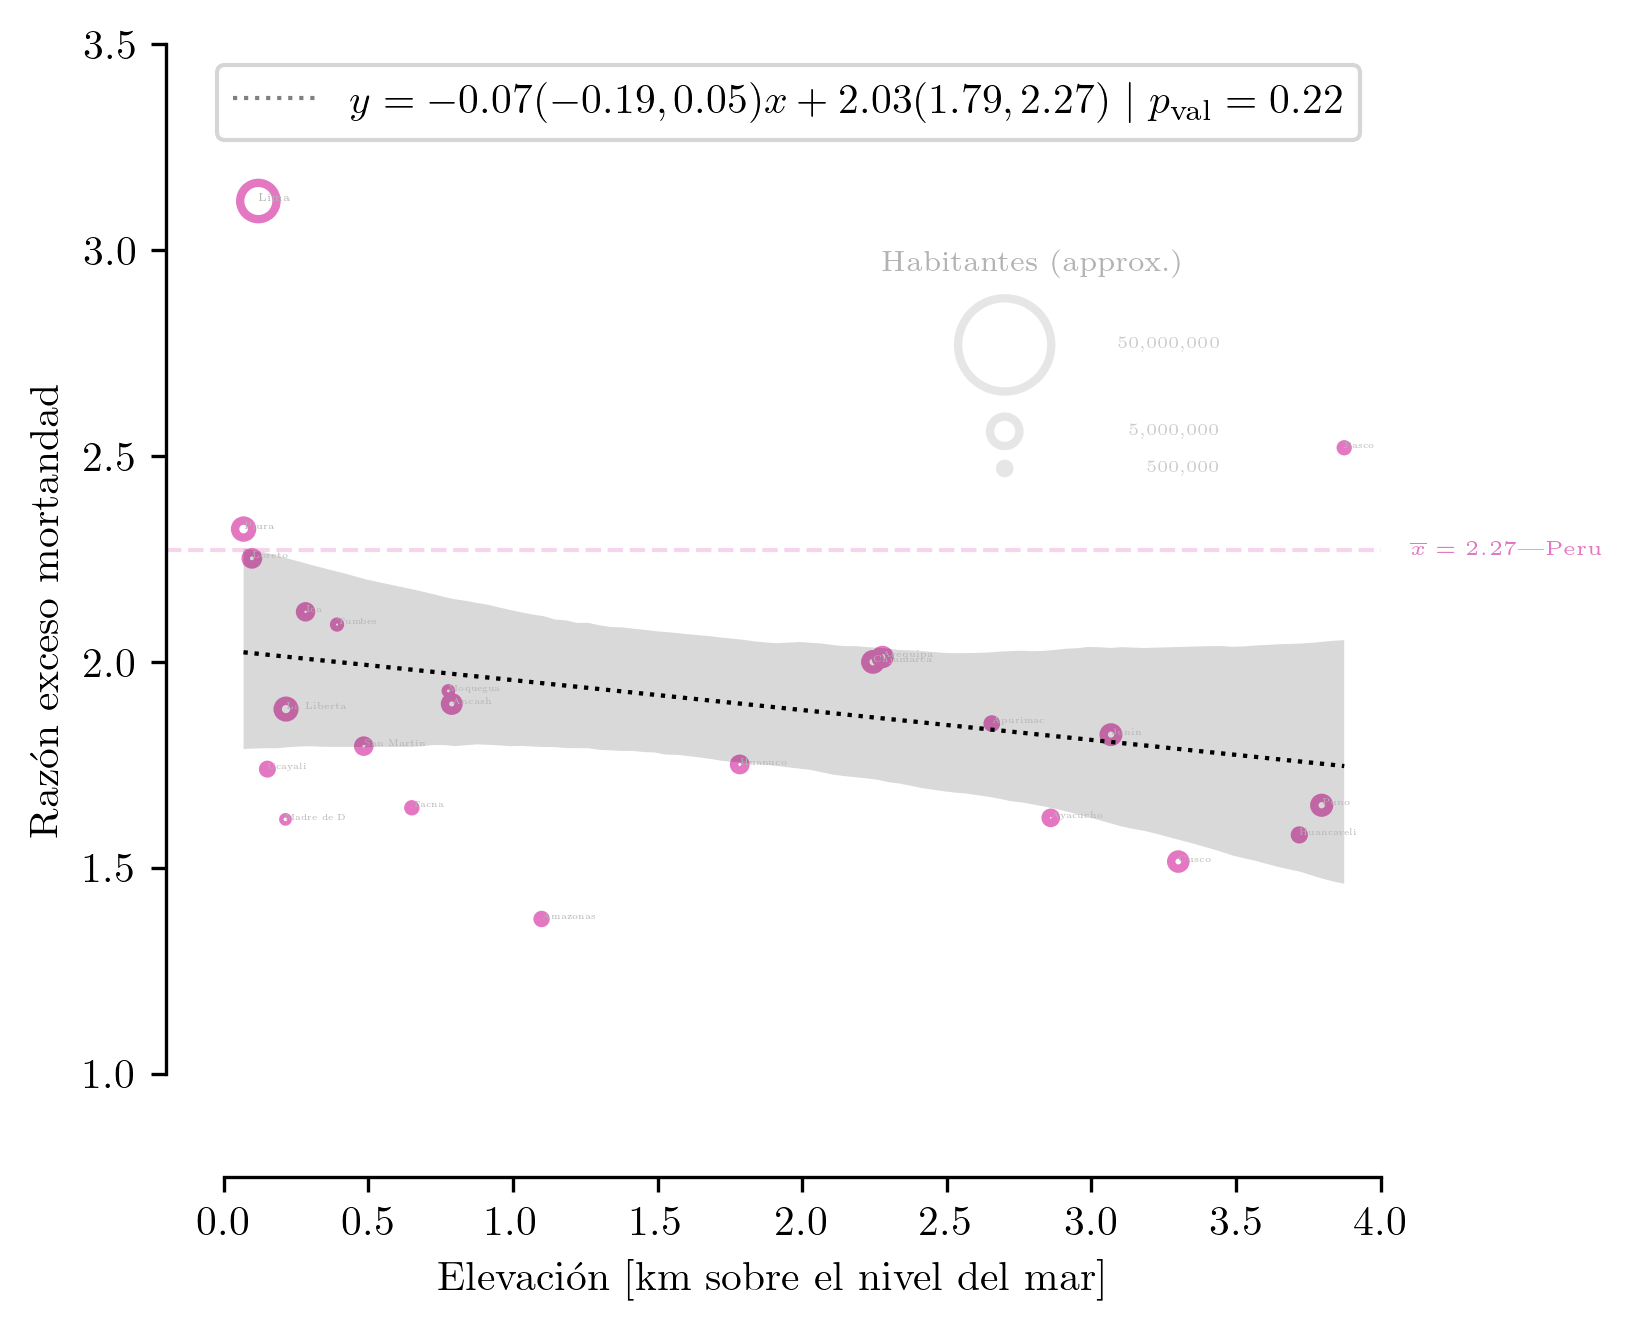

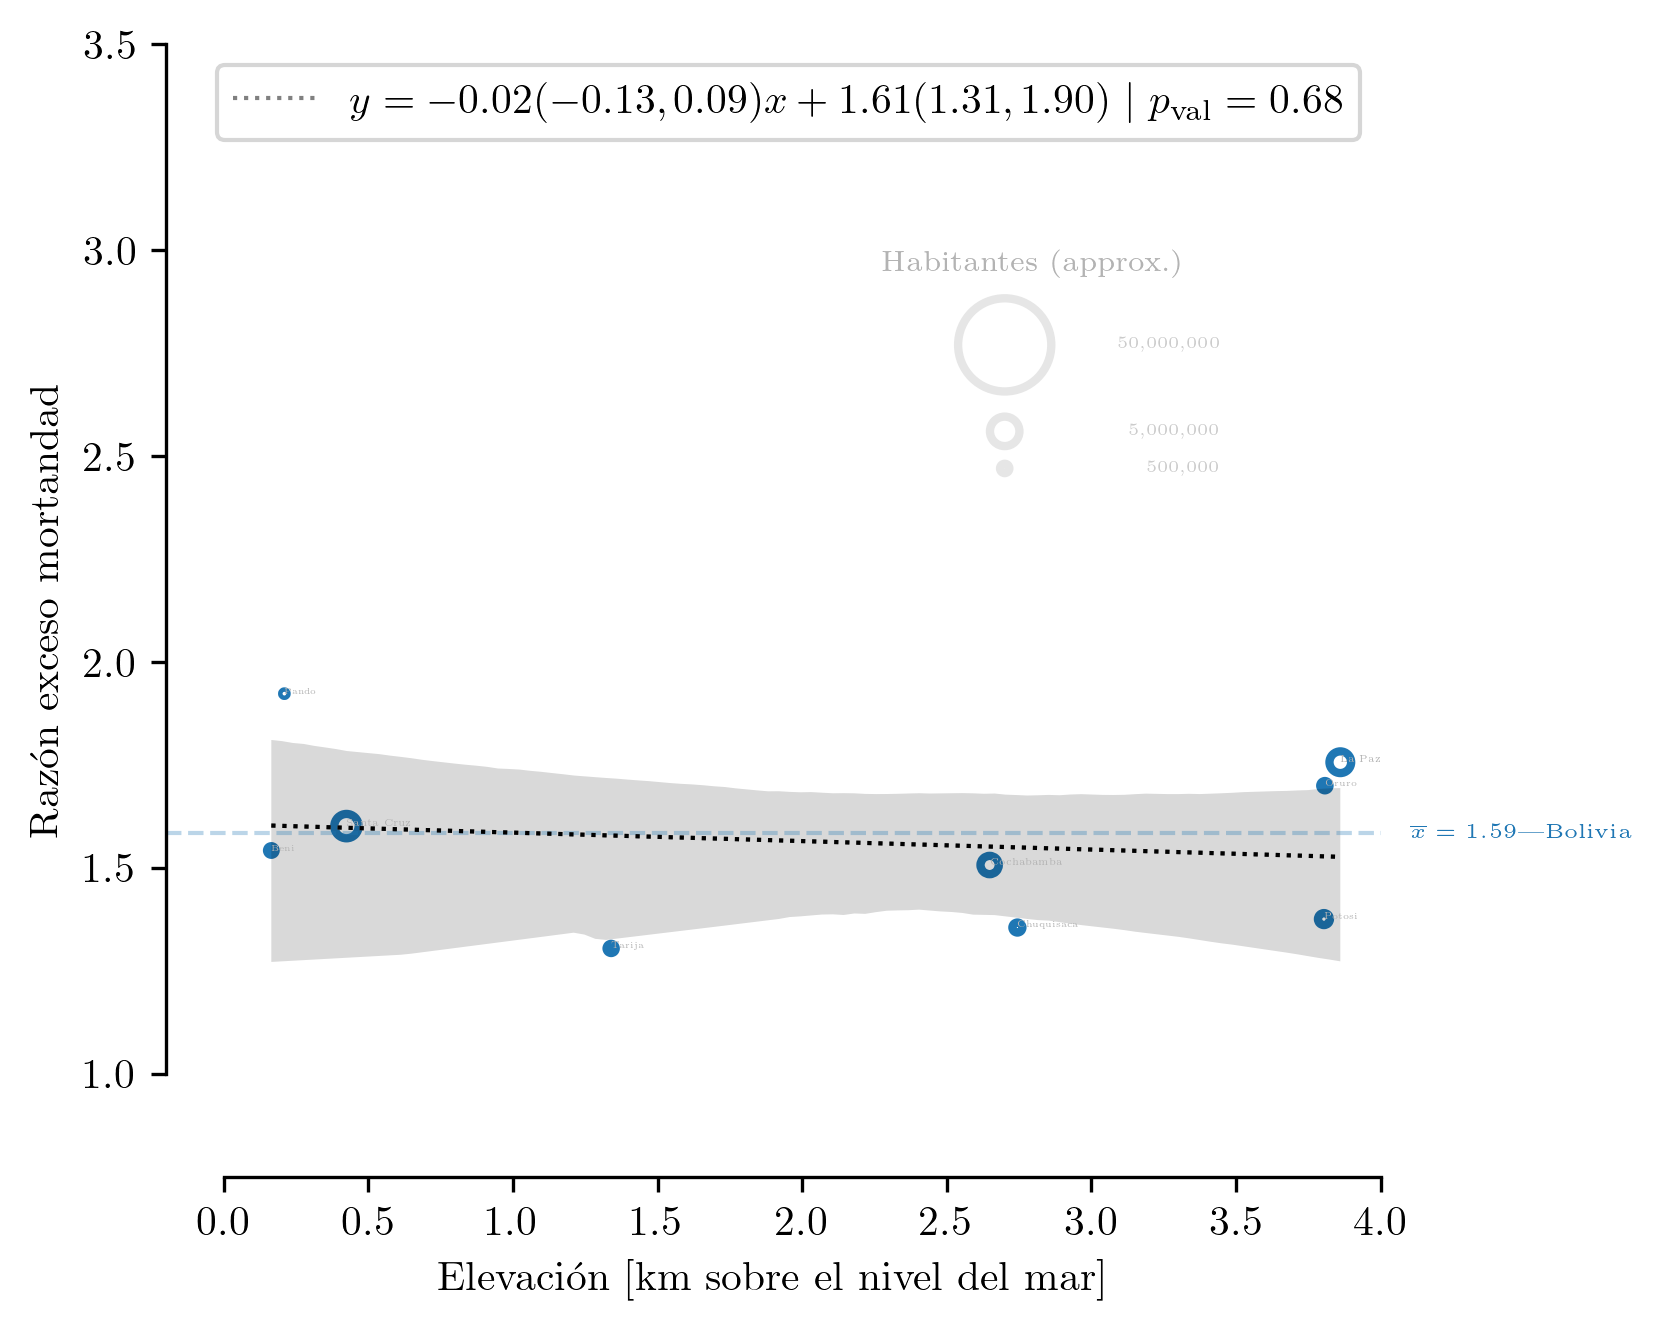

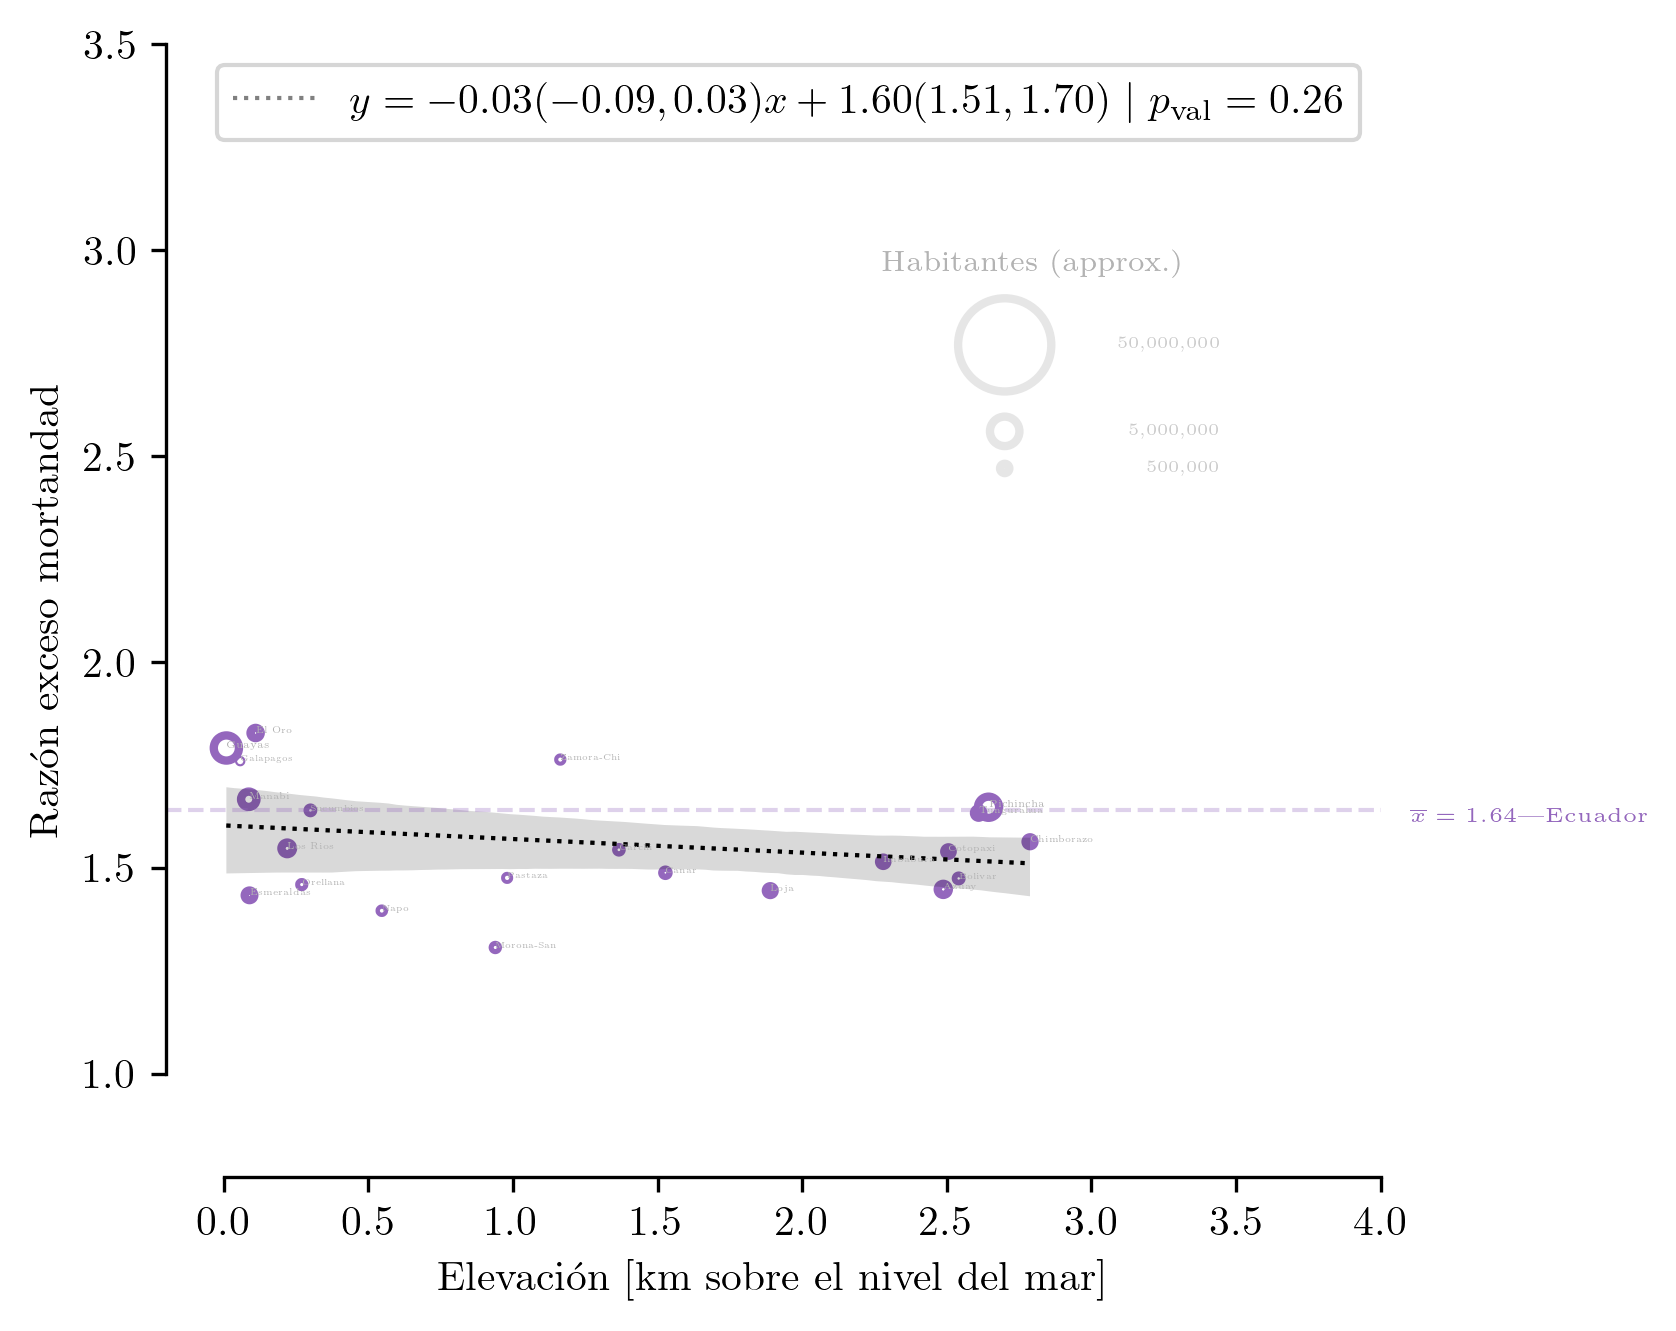

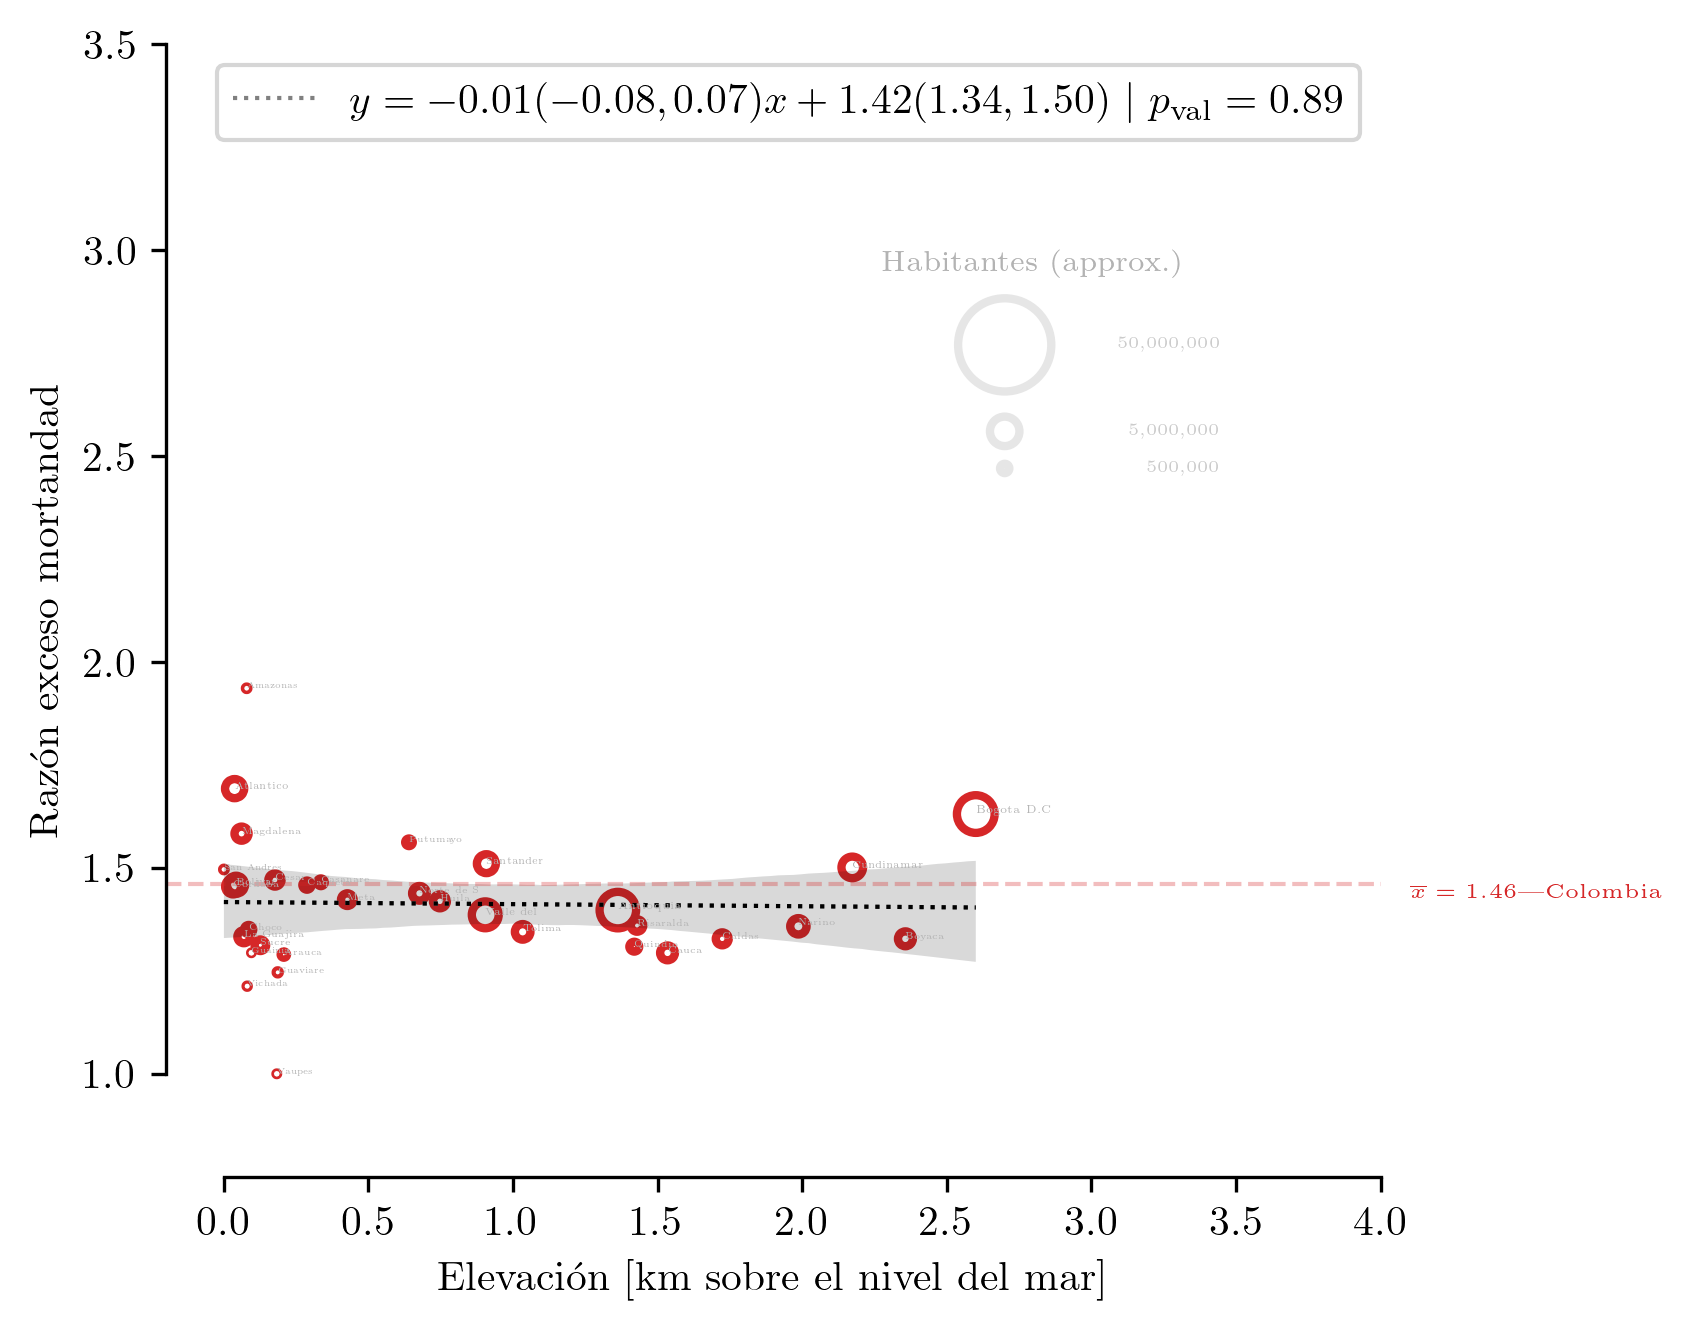

In [42]:
for Couns in Counss:
    f = './data/south.america.subnational.mortality.txt'

    df = pd.read_csv(f)

    IC,CN,AI,AN,FR,DT,DE = ('iso_code', 'country_name', 'adm1_isocode', 'adm1_name', 'frequency',
           'date', 'deaths')

    nam = df.drop_duplicates([CN,AN])[[CN,AN,AI]]

    con = df.drop_duplicates(CN)[CN]

    nam.to_csv('./data/coun_adm.csv')

    cdf = pd.read_csv('./data/city_data.csv',na_values='QuantityMagnitude[Missing["NotAvailable"]]')
    cdf['Elevation'] = cdf['Elevation']/1000



    g1= cdf.groupby('AdministrativeDivision')
    g= cdf.groupby('Country')

    c1 = cdf[cdf['Elevation'].notna()].copy()
    c1['pop_el'] = c1['Population']*c1['Elevation']

    g1 = c1.groupby('AdministrativeDivision')

    wh = (g1['pop_el'].sum()/g1['Population'].sum())
    wh.name = 'weighted_height'
    div = wh.to_frame()

    div['pop'] = g1['Population'].sum()

    from statsmodels.stats.weightstats import DescrStatsW

    st = {}
    for g,v in g1:
        values = v['Elevation']
        weights = v['Population']
        st[g]=DescrStatsW(values, weights=weights, ddof=1).std
    st = pd.Series(st)

    div['stw']=st

    d1 = div.sort_values('pop',ascending=False)

    df['dt']=pd.to_datetime(df['date'])
    df1 = df.set_index('dt')

    df2=df1.groupby(['adm1_isocode',pd.Grouper(freq='M')]).sum()['deaths'].unstack().T



    df3 = df2['2019-01-01':'2019-12-31']

    df3.index = df3.index.month

    df3.isna().sum().sum()

    mm = df2['2020-03':'2021-07']

    mm.index = mm.index.month

    m2 = mm.sum()/(mm * 0 + df3).sum()

    m1 = (mm/df3).mean()

    adm_dic=pd.read_csv('./data/adm_dic.csv')

    m2.name='ratio'
    m3 = m2.to_frame()

    f1 = pd.merge(m2,adm_dic,left_index=True, right_on='admi',how='inner',
             validate='1:1')



    f2 = pd.merge(d1.drop('pop',axis=1),f1,left_index=True,
             right_on='mname',validate='1:1')

    f2 = f2.sort_values('pop',ascending=False)
    f2 = f2[f2['ratio']<5]
    # bo=f2['country']=='Brazil'
    # f2 = f2[bo]

    cme = f2.groupby('country').median()

    f2 = pd.merge(cme,f2,left_on='country',right_on='country',suffixes=['_r',''])
    # f2['ratio']=f2['ratio']/f2['ratio_r']

    f2 = f2[f2['country'].isin(Couns)]


    # ax.set_ylim(.5,3)

    mea = f2['ratio'].mean()

    wmea = (f2['ratio']*f2['pop']).sum()/f2['pop'].sum()

    co = f2['country']

    dic_ = co.drop_duplicates().reset_index(drop=True).reset_index().set_index('country')['index'].to_dict()

    f2['ci']=f2['country'].replace(dic_)

    cm = plt.get_cmap('tab10')

    cs = [cm(i) for l,i in f2['ci'].items()]

    from sklearn.linear_model import QuantileRegressor,LinearRegression

    qr = QuantileRegressor(alpha=0)
    qr1 = LinearRegression()
    qr2 = LinearRegression()

    from sklearn.preprocessing import StandardScaler

    f2_ = f2.sort_values('weighted_height')
    X = f2_[['weighted_height']]
    y = f2_[['ratio']]

    s1 = StandardScaler()
    s2 = StandardScaler()

    X1 = s1.fit_transform(X)
    y1 = s2.fit_transform(y)

    qr.fit(X1,y1[:,0])
    qr1.fit(X1,y1[:,0])
    qr2.fit(X,y.values[:,0])

    yp11 = qr.predict(X1)
    yp12 = qr1.predict(X1)
    yp13 = qr2.predict(X)

    yp111 = s2.inverse_transform(yp11.reshape(-1,1))[:,0]
    yp112 = s2.inverse_transform(yp12.reshape(-1,1))[:,0]
    
    _x = f2_['weighted_height'].values
    _y = f2_['ratio'].values
    
    import statsmodels.api as sm
    import numpy as np

    # include constant in ols models, which is not done by default
    _x = sm.add_constant(_x)

    model = sm.OLS(_y,_x)
    results = model.fit()
    
    s=results.summary2()
    c1,x1 = s.tables[1]['[0.025']
    c2,x2 = s.tables[1]['0.975]']
    
    lm[Couns[0]]=results
    



    means = {}
    wmeans_ = {}
    fits = {}
    f_xy = {}
    for c in dic_.keys():
        boo = f2['country']==c
        means[c]=f2[boo]['ratio'].mean()
        _f = f2[boo].sort_values('weighted_height')
        wm = (_f['ratio'] * _f['pop']).sum()/_f['pop'].sum()
        wmeans_[c]=wm


        lr = QuantileRegressor(alpha=0)
    #     lr = LinearRegression()
        _X = _f[['weighted_height']]
        _y = _f['ratio']
        lr.fit(_X,_y)
        fits[c] = lr
        f_xy[c] = [_X.values[:,0],lr.predict(_X)]


    means = pd.Series(means).sort_values(ascending=False).to_dict()
    dic = {}
    wmeans = {}
    for i,v in means.items():
        dic[i] = dic_[i]
        wmeans[i] = wmeans_[i]

    dic = {
        'Peru': 6,
     'Bolivia': 0,
     'Ecuador': 4,
     'Colombia': 3,
     }

    dic = {c:dic[c] for c in Couns }




    doff = {
        'Peru': 0,
         'Bolivia': 0,
         'Ecuador': -.015,
         'Colombia': -.02,
         'Brazil': 0,
         'Paraguay': 0,
         'Chile': 0,
         'Uruguay': 0
    }

    coef = np.round(np.round(qr2.coef_[0],2)+.000000001,2)

#     fy = f'  $y = {coef:.2f} ({x1:.2f},{x2:.2f}) x + {qr2.intercept_:.2f}({c1:.2f},{c2:.2f})$'
    
    pval = results.summary2().tables[1]['P>|t|']['x1']

    fy = f'  $y = {coef:.2f} ({x1:.2f},{x2:.2f}) x + {qr2.intercept_:.2f}({c1:.2f},{c2:.2f})\\ |\\ p_{{\\rm{{val}}}}={pval:.2f}$'

    f2['ci']=f2['country'].replace(dic)
    cs = [cm(i) for l,i in f2['ci'].items()]

    plt.rcParams.update({
      "text.usetex": True,
      "font.family": "Helvetica"
    })

    f,ax= plt.subplots(dpi=300,figsize=(6,5))
    ax.scatter(
        f2['weighted_height'],
        f2['ratio'],
        s=f2['pop']/100000,
        edgecolors=cs,
        lw=2,
        facecolor='none'
    )
    ax.set_ylim(.75,3.5)
    ax.set_xlim(-.2,4)
#     ax.axhline(wmea,c='.5',ls='--',lw=1)
    ax.plot(X.values[:,0],yp13,ls=':',c='.5',lw=1,label=fy)
    ax.legend()
#     ax.text(X.values[-1,0],yp13[-1],fy,va='center',fontsize=6,c='.5')



    sns.despine(f,trim=True)


    # al = {0:'bottom',1:'top'}

    for i,c in enumerate(dic.keys()):
        ax.axhline(wmeans[c],alpha=.3,lw=1,ls='--',c=cm(dic[c]))
    #   ax.plot(*f_xy[c],ls='-.',lw=1,alpha=.5)
    #   ax.text(.5,1-i/20,c,transform=ax.transAxes,c=cm(dic[c]))
        ax.text(4.1,wmeans[c]+doff[c],f'$\overline{{x}}={wmeans[c]:.2f}$|{c}',
                fontsize=5,c=cm(dic[c]),va='center')
        pass

#     ax.text(4.1,wmea,f'$\overline{{x}}={wmea:.2f}$|prom regional',
#             fontsize=5,c='.5',va='center')

    for i,r in f2.iterrows():
        ax.text(r['weighted_height'],r['ratio'],
               r['adm'][:10], fontsize = (r['pop'])**.5/5000+2,
                c='.7'
               )
    xx = [2.7,2.7,2.7]
    
    YY = .2
    yy = np.array([2.57,2.36,2.27])+ YY
    pp = [5e7,5e6,5e5]
    ax.scatter(
        xx,
        yy,
        s=np.array(pp)/100000,
        lw=2,
        facecolor='none',
        edgecolor='.9')

    for x,y,p in zip(xx,yy,pp):
        ax.text(x+.75,y,f'{int(p):,}',va='center',ha='right',fontsize=4,c='.8')

    ax.text(xx[0]+.1,2.75 + YY,'Habitantes (approx.)',fontsize=7,c='.7',ha='center')
    
    sns.regplot(x=_x[:,1],y=_y,scatter=False,line_kws={'lw':1,'color':'k','ls':':'},ax=ax)
    ax.set_ylabel('Razón exceso mortandad')
    ax.set_xlabel('Elevación [km sobre el nivel del mar]')
    f.subplots_adjust(right=.8)
    f.savefig(f'reg_alt_alt{Couns[0]}.pdf')
    f.savefig(f'reg_alt_alt{Couns[0]}.png')

In [43]:
for l,v in lm.items():
    print(l+'\n\n')
    print(v.summary2())

Peru


                Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.027  
Dependent Variable: y                AIC:                21.8458
Date:               2021-12-30 19:56 BIC:                24.1168
No. Observations:   23               Log-Likelihood:     -8.9229
Df Model:           1                F-statistic:        1.614  
Df Residuals:       21               Prob (F-statistic): 0.218  
R-squared:          0.071            Scale:              0.13932
------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
------------------------------------------------------------------
const      2.0286     0.1166   17.4018   0.0000    1.7862   2.2710
x1        -0.0726     0.0572   -1.2705   0.2178   -0.1915   0.0463
----------------------------------------------------------------
Omnibus:             13.744       Durbin-Watson:          1.529 
Prob(Omnibus):       0.00

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
